# import Library

In [2]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Load DF

In [3]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

# Experience class

In [4]:
Experience = namedtuple("Experience", ["s","a","r","n_s","d"])

# Action class

In [5]:
class Action(Enum):
    BUY  = -1
    STAY = 0
    SELL = 1

# PlotTrade class

In [6]:
class PlotTrade():
    
    
    def __init__(self, df_chart):
        self.df_chart = df_chart
        plt.clf()
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.plot(self.df_chart)
        
        
        
    def add_span(self, start_time,end_time):
        self.ax.axvspan(start_time, end_time, color="gray", alpha=0.3)
        
    
    def add_plot(self, df_plot):
        self.ax.plot(df_plot)
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()    
        

# ValidatePlot class

In [7]:
class ValidatePlot(PlotTrade):
    
    
    def __init__(self, df_chart, is_validate=False):
        pass
        
    def add_span(self, start_time,end_time):
        pass
        
    
    def add_plot(self, df_plot):
        pass
        
        
    def show(self):
        pass

# Environment class    

In [8]:
class Environment():
    
    
    def __init__(self, x_train, price_chart):
        self.x_train = x_train # state list
        self.is_holding = False
        self.time = 0 # x_trainのindex
        self.price_chart = price_chart
        self.bought_price = 0
        
        
    def reset(self):
        self.time=0
        self.is_holding = False
        self.bought_price = 0
        return self.x_train.iloc[self.time].tolist()
        
    
    def actions(self):
        return [Action.BUY, Action.STAY, Action.SELL]
    
    
    
    def state(self):
        return self.x_train.iloc[self.time].tolist()
  
            
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return reward, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return reward, False
            
    
    
    def step(self, action):
        reward, done = self.reward_func(action)
        self.time += 1
        next_state = self.state()
        
    
        return next_state, reward, done

# SigmoidEnv class

In [9]:
class SigmoidEnv(Environment):

    
    def sigmoid(self, x_):
        return 1/(1+np.exp(-x_))
    
     
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return 2*self.sigmoid(reward)-1, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return 2*self.sigmoid(reward)-1, False


# TanhEnv class

In [10]:
class TanhEnv(Environment):

 
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return np.tanh(reward), True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return np.tanh(reward), False


# Agent class

In [11]:
class FNAgent():
    
    
    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False
        
        
    def save(self, model_path):
        self.model.save(model_path, overwrite=True, include_optimizer=False)
        
        
    def policy(self, s):# 買ってたら戦略が変わる

        if np.random.random() < self.epsilon or not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                return np.random.choice(self.actions,size=1, p=estimates)[0]
            else:
                return np.argmax(estimates)
        
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent
    
    
    def initialize(self, experiences):
        pass
        
        
    def estimate(self, s):
        pass
        
        
    def update(self, experiences, gamma):
        pass
        
        
    def play(self, env, episode_count=1):
        pass

## env.time のインデックスについての注意
env.step()で time＋１ となり, 次の状態に遷移するが, 購入(売却)するのもこのインデックスなので, 問題はない

# Trainer class

In [12]:
class Trainer():

    
    def __init__(self, buffer_size=1024, batch_size=32,gamma=0.9):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        

    def train_loop(self, env,agent, episode=200, initial_count=-1,env_sample=None):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        actions = env.actions()
        reward_log = []
        validate_reward_log = []
        
        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            total_rewards = 0
            
            if i%100==0:
                print("----------------------")
                print("episode :",i)
            
            while not done:
                

                a = agent.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                e = Experience(s, a, reward, n_state, done)
                total_rewards += reward
                self.experiences.append(e)
                
                
                if not self.training and len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
#                 self.episode_end(i, step_count, agent)
                
                reward_log.append(total_rewards)
#         検証用のlog
                if env_sample!=None:
                    validate_reward, dummy = agent.play(env_sample,is_validate=True)
                    validate_reward_log.append(validate_reward)
                if not self.training and initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True


                if self.training:
                    self.training_count += 1
                    

        print("train reward")         
        plt.clf() 
        plt.plot(reward_log)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.show()
        
        
        if env_sample!=None:
            print("validate data reward")
            plt.clf() 
            plt.plot(validate_reward_log)
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.show()
    
    def episode_begin(self, episode, agent):
        pass

    
    def begin_train(self, episode, agent):
        pass

    
    def step(self, episode, step_count, agent, experience):
        pass

    
    def episode_end(self, episode, step_count, agent):
        pass

    
    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    
    def get_recent(self, count):
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]



# Value function Agent class

In [13]:
class ValueFunctionAgent(FNAgent):

    
    def save(self, model_path):
        joblib.dump(self.model, model_path)

    
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    
    def initialize(self, experiences):
        scaler = StandardScaler() # 特徴料(列)ごとに標準化してる
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        states = np.vstack([e.s for e in experiences])
        self.model.named_steps["scaler"].fit(states)

        # Avoid the predict before fit.
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    
    def estimate(self, s):
        s = np.array(s).reshape(1,-1)
        estimated = self.model.predict(s)[0]
        return estimated

    
    def _predict(self, states):
        if self.initialized:
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        return predicteds

    
    def update(self, experiences, gamma):
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])

        estimateds = self._predict(states)
        future = self._predict(n_states)


        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)
        
        
    def play(self, env, episode_count=1,is_validate=False):
        actions = env.actions()
        
        for e in range(episode_count):

            s = env.reset()
            done = False
            total_reward = 0
            reward_log = []
            if not is_validate:
                pl = PlotTrade(env.price_chart)
            else:
                pl = ValidatePlot(None,is_validate=is_validate)
            trade_count = 0
            is_bought = False
            start_time = env.price_chart.index[0]
            end_time = env.price_chart.index[0]
                
            
            while not done:
                a = self.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                total_reward += reward
                s = n_state
                reward_log.append(total_reward)
                #============ render ============

                
                if not is_bought:
                    if env.is_holding and action == Action.BUY:
                        start_time = env.price_chart.index[env.time]
                        is_bought = True
                else:
                    if not env.is_holding and action == Action.SELL:
                        end_time = env.price_chart.index[env.time]
                        is_bought = False
                        pl.add_span(start_time,end_time)
                        trade_count += 1

                    
            else:
                if is_bought and env.is_holding:
                    end_time = env.price_chart.index[env.time]
                    pl.add_span(start_time,end_time)
                    trade_count+=1
                    
                if not is_validate:
                    print("==================")
                    print("episode :",e) 
                    print("Get reward {}.".format(total_reward))
                    print("Trade count {}.".format(trade_count))
                    pl.show()
                return  total_reward, trade_count


# Memo


Q-learningは\
gain = reward + gamma * max(Q\[state\]) \
としているため, off-policy

一方SARSA法は \
gain = reward + gamma * Q\[state\]\[action\] \
としているため, on-policy

# Value function Trainer

In [14]:
class ValueFunctionTrainer(Trainer):

    
    def train(self, env, episode_count=250, epsilon=0.01, initial_count=-1,env_sample=None):
        actions = list(range(len(Action)))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count,env_sample)
        return agent

   
    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    
    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)
      
    
    def episode_end(self, episode, step_count, agent):
#         rewards = [e.r for e in self.get_recent(step_count)]
        pass
        

# make train data

入力 : DAW, TPIXの1次の変化率

In [15]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'

def make_x_train(path_):
    path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
    df_tpx  = DataFramePreProcessing(path_).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx['close']],axis = 1,join='inner').astype(float)

    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp['close'].iloc[1:]
    return x_train, price_chart


# make train data2

入力 : DAW, TOPIXの移動平均

In [16]:
def make_x_train2(path_,ma_short=5,ma_long=25):
    path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
    df_tpx  = DataFramePreProcessing(path_).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx['close']],axis = 1,join='inner').astype(float)
    
    
#             df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
#         df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        
    df_tmp['ma_short'] = df_tmp['close'].rolling(ma_short).mean()
    df_tmp['ma_long']  = df_tmp['close'].rolling(ma_long).mean()

    x_train = df_tmp.loc[:,['dclose','pclose','ma_short','ma_long']].iloc[ma_long:]
    price_chart = df_tmp['close'].iloc[ma_long:]
    return x_train, price_chart

# main

In [17]:
x_train, price_chart = make_x_train2(path_tpx)

In [18]:
x_train.head()
price_chart.head()

day
2011-08-11    776.0
2011-08-12    772.0
2011-08-15    780.0
2011-08-16    784.0
2011-08-17    781.0
Name: close, dtype: float64

In [21]:
train_year = 2020
test_year = 2021
s_train = x_train[x_train.index.year==train_year]
s_test = x_train[x_train.index.year==test_year]
s_train

,dclose,pclose,ma_short,ma_long
day,,,,
2020-01-06,0.002392,-0.013460,1783.2,1782.16
2020-01-07,-0.004170,0.017055,1784.6,1782.80
2020-01-08,0.005647,-0.013415,1779.2,1782.64
2020-01-09,0.007369,0.016431,1778.0,1784.12
2020-01-10,-0.004598,0.003344,1781.4,1785.04
...,...,...,...,...
2020-12-24,0.002325,0.004907,1845.2,1839.28
2020-12-25,0.000000,0.001085,1841.6,1841.48
2020-12-28,0.006758,0.005962,1841.2,1844.04


################
prf
----------------------
episode : 0
Done initialization. From now, begin training!
----------------------
episode : 100
----------------------
episode : 200
----------------------
episode : 300
----------------------
episode : 400
----------------------
episode : 500
----------------------
episode : 600
----------------------
episode : 700
----------------------
episode : 800
----------------------
episode : 900
----------------------
episode : 1000
----------------------
episode : 1100
----------------------
episode : 1200
----------------------
episode : 1300
----------------------
episode : 1400
----------------------
episode : 1500
----------------------
episode : 1600
----------------------
episode : 1700
----------------------
episode : 1800
----------------------
episode : 1900
----------------------
episode : 2000
----------------------
episode : 2100
----------------------
episode : 2200
----------------------
episode : 2300
----------------------
episode :

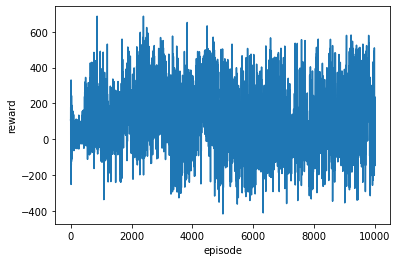

validate data reward


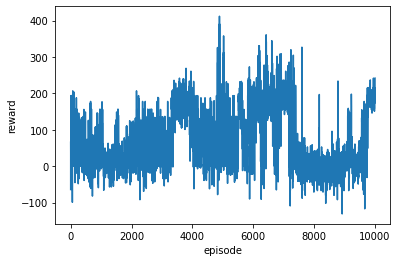

episode : 0
Get reward 194.0.
Trade count 1.


<Figure size 432x288 with 0 Axes>

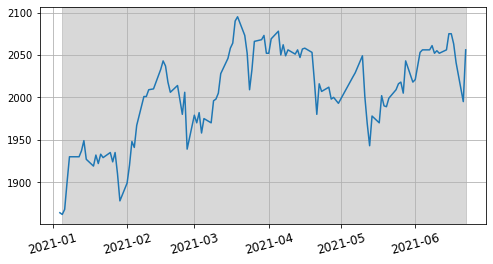

################
sigmoid
----------------------
episode : 0
Done initialization. From now, begin training!
----------------------
episode : 100
----------------------
episode : 200
----------------------
episode : 300
----------------------
episode : 400
----------------------
episode : 500
----------------------
episode : 600
----------------------
episode : 700
----------------------
episode : 800
----------------------
episode : 900
----------------------
episode : 1000
----------------------
episode : 1100
----------------------
episode : 1200
----------------------
episode : 1300
----------------------
episode : 1400
----------------------
episode : 1500
----------------------
episode : 1600
----------------------
episode : 1700
----------------------
episode : 1800
----------------------
episode : 1900
----------------------
episode : 2000
----------------------
episode : 2100
----------------------
episode : 2200
----------------------
episode : 2300
----------------------
episo

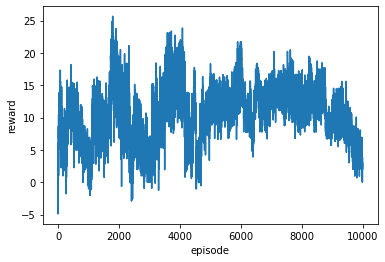

validate data reward


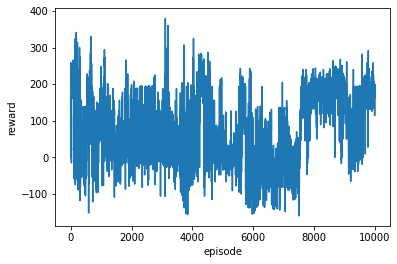

episode : 0
Get reward 194.0.
Trade count 1.


<Figure size 432x288 with 0 Axes>

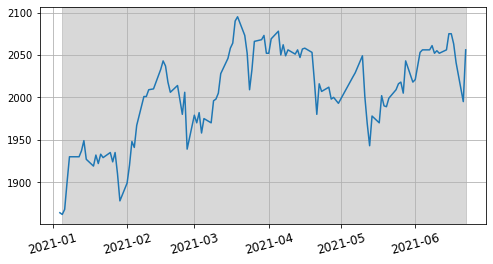

################
tanh
----------------------
episode : 0
Done initialization. From now, begin training!
----------------------
episode : 100
----------------------
episode : 200
----------------------
episode : 300
----------------------
episode : 400
----------------------
episode : 500
----------------------
episode : 600
----------------------
episode : 700
----------------------
episode : 800
----------------------
episode : 900
----------------------
episode : 1000
----------------------
episode : 1100
----------------------
episode : 1200
----------------------
episode : 1300
----------------------
episode : 1400
----------------------
episode : 1500
----------------------
episode : 1600
----------------------
episode : 1700
----------------------
episode : 1800
----------------------
episode : 1900
----------------------
episode : 2000
----------------------
episode : 2100
----------------------
episode : 2200
----------------------
episode : 2300
----------------------
episode 

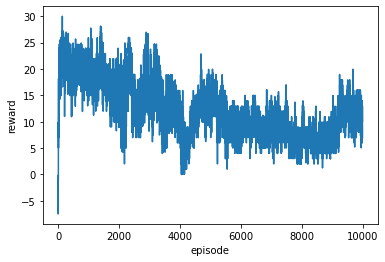

validate data reward


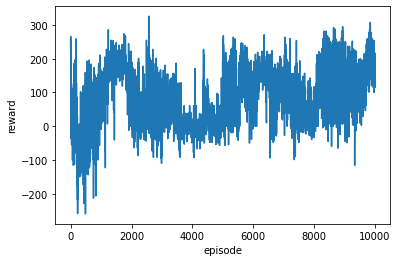

episode : 0
Get reward 183.0.
Trade count 3.


<Figure size 432x288 with 0 Axes>

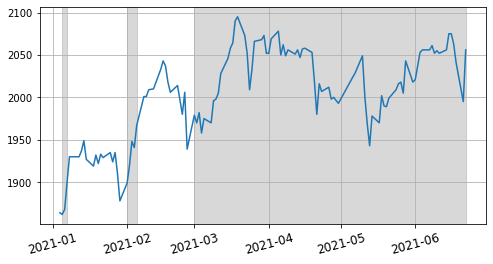

(183.0, 3)

In [20]:
x_train, price_chart = make_x_train2(path_tpx)


train_year = 2020
test_year = 2021
episode_count = 10000

s_train = x_train[x_train.index.year==train_year]
s_test = x_train[x_train.index.year==test_year]

price_train = price_chart[price_chart.index.year==train_year]
price_test  = price_chart[price_chart.index.year==test_year]

print("################")
print("prf")
env_train = Environment(s_train,price_train)
env_test = Environment(s_test,price_test)
trainer = ValueFunctionTrainer()
trained = trainer.train(env_train,episode_count=episode_count,env_sample=env_test)   
trained.play(env_test)

print("################")
print("sigmoid")
env_train = SigmoidEnv(s_train,price_train)
env_test = Environment(s_test,price_test)
trainer = ValueFunctionTrainer()
trained = trainer.train(env_train,episode_count=episode_count,env_sample=env_test)   
trained.play(env_test)

print("################")
print("tanh")
env_train = TanhEnv(s_train,price_train)
env_test = Environment(s_test,price_test)
trainer = ValueFunctionTrainer()
trained = trainer.train(env_train,episode_count=episode_count,env_sample=env_test)   
trained.play(env_test)


In [ ]:
３０分で400エピソード